# Topic Modelling with Big ARTM

In this notebook, we will perform topic modelling on the french texts from the DFKV illustrations project. Doc for ARTM usage [here](https://bigartm.readthedocs.io/en/stable/tutorials/python_userguide/index.html).

We start by installing the package.

In [1]:
!pip install bigartm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 8.4 MB/s 


Then we load our Google Drive content, to be able to use our images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


And we navigate to the right directory.

In [3]:
%cd drive/MyDrive/text/

/content/drive/MyDrive/text


We start by creating our batches using the vectorizer from the package. We have our `docword.dfkv.txt` and `vocab.dfkv.txt` files (in Bag of Words UCI format) in the same folder as our notebook.

In [4]:
import artm
import matplotlib.pyplot as plt
import math
import numpy as np
import random
from tqdm import tqdm
import pandas as pd

batch_vectorizer = artm.BatchVectorizer(data_path='',
                                        data_format='bow_uci',
                                        collection_name='dfkv',
                                        target_folder='data')

Then, we also need to create our dictionnary, which is in our case in `vocab.dfkv.txt`. Here the data path is where the batches are, the emplacement that was defined previously as the target folder.

In [5]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='data',
                  vocab_file_path='vocab.dfkv.txt')

Let's also define here a set of parameters that we will finetune later, there role will be explained when they are used, we can just use the default values for now.

In [6]:
NUM_TOPICS = 20 
NUM_TOKENS = 12
TAU_DECORRELATOR = 30000
TAU_PHI = -0.75
TAU_THETA = -1.25

And we can start to build our model ! It is basically a matrix of size "Number of words in dictionnary" X "Number of topics", which is randomly initialized.

In [7]:
# ARTM model
# We choose here the number of topics that we want in our texts
model = artm.ARTM(num_topics=NUM_TOPICS, dictionary=dictionary, cache_theta=False)

Then, we want to add ways to measure how good our model performs : scores. Let's explain breifely the ones we use, but a more complete description is available [here](https://bigartm.readthedocs.io/en/stable/tutorials/scores_descr.html)  :
- Perplexity : indicates speed of convergence of the model. The smaller the better
- Sparsity Phi : ratio of elements of the Phi matrix that are less than a given threshold. Used to control regularization, the goal is to have a sparse matrix.
- Sparsity Theta : ratio of elements of the Theta matrix that are less than a given threshold. Used to control regularization, the goal is to have a sparse matrix.
- Top Tokens : to check topic quality, will return top words for each topic. Can also compute coherence of the top tokens.

Other scores are available for the model, you can look them up at the page for scores descriptions.


In [8]:
# Adding scores
model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      dictionary=dictionary))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score'))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score_10_topics', topic_names=model.topic_names[0: 9]))
# To show the number of most probable words in each topic
model.num_tokens = NUM_TOKENS

We will also add a regularizer from the beginning (see [documentation](https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html) for more infos about regularizers) : the decorrelator Phi that decorrelates columns in the Phi matrix (e.g. make topics more different), that allows to increase the interpretability of topics.

In [9]:
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer'))
model.regularizers['decorrelator_phi_regularizer'].tau = TAU_DECORRELATOR

Now we can start training the model ! We use the fit_offline algorithm, which does many passes through the collection, one pass through the single document (optional), only one update of the PHI matrix on one collection pass (at the end of the pass).

In [10]:
N_FIRST_PASSES = 13
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=N_FIRST_PASSES)

Let us look at our scores throughout the different iterations

In [11]:
def plot_scores(score_tracker):
  to_plot = [k for k in score_tracker.keys() if k != "top_tokens_score"]
  n_scores = len(to_plot)
  columns = 2
  lines = math.ceil(n_scores/2)
  fig, axs = plt.subplots(lines, columns, figsize=(8*lines, 8))
  for i, score in enumerate(to_plot):
    axs[math.ceil(i/2) - 1][i%2].plot(range(len(model.score_tracker[score].value)), model.score_tracker[score].value)
    axs[math.ceil(i/2) - 1][i%2].title.set_text(score)
  fig.suptitle('Different scores of the model through iterations')

In [12]:
def print_topics():
  saved_top_tokens = model.score_tracker['top_tokens_score'].last_tokens

  for topic_name in model.topic_names:
    print(saved_top_tokens[topic_name])

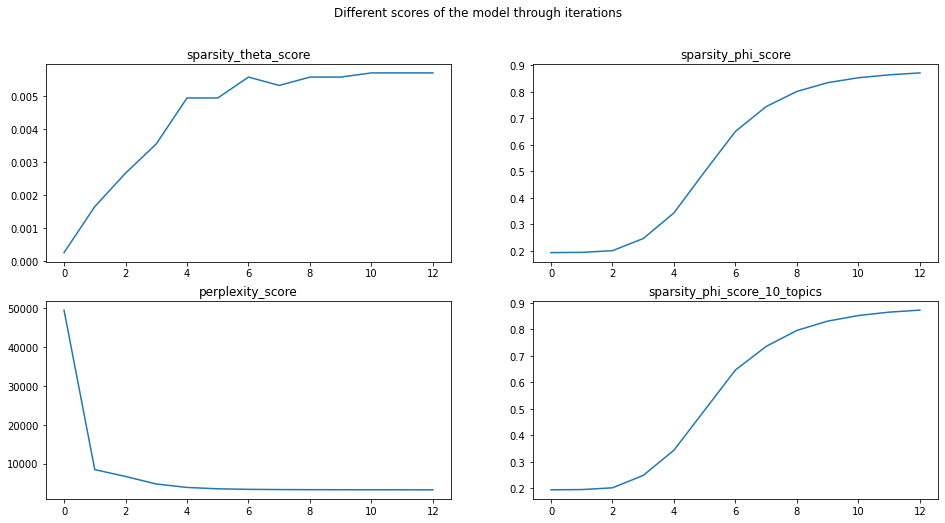

In [13]:
plot_scores(model.score_tracker)

In [14]:
print_topics()

['art', b'\xe9t\xe9', 'exposition', 'paris', 'bien', 'temps', 'grand', 'arts', 'esprit', 'mieux']
['busch', 'bien', 'art', 'vie', 'artistes', 'grand', 'faire', b'\xe9t\xe9', 'dessin', 'petit']
['art', 'exposition', 'peinture', 'bien', b'th\xe9\xe2tre', 'portrait', 'grand', b'mus\xe9e', b'si\xe8cle', 'paris']
['art', 'fut', b'mus\xe9e', 'suisse', 'lenbach', b'mar\xe9es', 'peintre', 'peinture', 'bien', b'\xe9t\xe9']
['durer', 'art', b'mus\xe9e', 'peinture', b'si\xe8cle', 'vie', 'artistes', 'artiste', 'saint', b'ma\xeetre']
['exposition', 'art', 'artistes', 'venise', 'bien', 'grand', 'oeuvres', 'galerie', 'peintres', 'kandinsky']
['art', 'exposition', b'\x9cuvres', 'faire', 'bien', 'fig', b'\x9cuvre', 'paris', 'grand', 'galerie']
['holbein', 'art', b'mus\xe9e', 'portrait', 'durer', 'portraits', 'artiste', 'dessins', 'oeuvre', 'grand']
['dada', 'bien', 'maison', 'air', 'gropius', 'temps', 'contre', 'vie', 'france', 'salle']
['art', 'bien', 'artistes', b'\x9cuvre', 'grand', b'\xe9t\xe9', 'a

After a few passes, we see that the different scores have all converged.However, we could get even better topics by adding more regulizers. Again, more information about them can be found in the [documentation](https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html).
- Smooth Sparse Phi : simply smooth or sparse all values in the Phi matrix
- Smooth Sparse Theta : simply smooth or sparse all values in the Theta matrix

In [15]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'))

model.regularizers['sparse_phi_regularizer'].tau = TAU_PHI
model.regularizers['sparse_theta_regularizer'].tau = TAU_THETA

And we fit for 13 more passes the model, with the new regularizers.

In [16]:
N_SECOND_PASSES = 13
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=N_SECOND_PASSES)

And again look at the scores and topics found

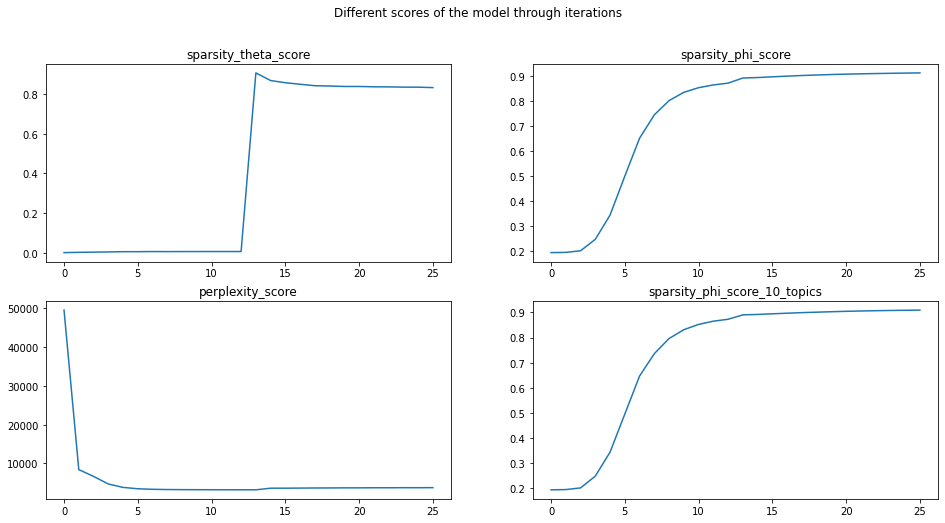

In [17]:
plot_scores(model.score_tracker)

In [18]:
print_topics()

['art', 'exposition', b'\xe9t\xe9', 'paris', 'arts', 'bien', 'grand', 'temps', 'mieux', 'donner']
['busch', 'bien', 'art', 'vie', 'grand', 'petit', 'dessin', 'faire', 'artistes', 'femmes']
['art', 'portrait', 'courbet', 'exposition', 'bien', 'peinture', b'th\xe9\xe2tre', 'paris', 'leibl', b'si\xe8cle']
[b'mus\xe9e', 'art', 'fut', 'suisse', 'lenbach', b'mar\xe9es', 'peintre', b'\xe9t\xe9', 'munich', 'ville']
['art', 'durer', 'peinture', 'vie', b'mus\xe9e', 'artistes', b'si\xe8cle', b'ma\xeetre', 'allemagne', 'artiste']
['art', 'exposition', 'artistes', 'venise', 'oeuvres', 'grand', 'peintres', 'talent', 'bien', 'artiste']
['art', 'galerie', 'exposition', b'\x9cuvres', b'\x9cuvre', 'faire', 'peinture', 'paris', 'peintre', 'rue']
['holbein', 'art', 'portrait', b'mus\xe9e', 'dessins', 'portraits', 'artiste', 'oeuvre', 'dessin', 'durer']
['maison', 'gropius', 'air', 'bien', 'temps', 'vue', 'contre', 'salle', 'architecture', 'construction']
['art', 'bien', b'\x9cuvre', 'moderne', 'arts', 'ar

We see that the scores and the topics definitely improved with the second passes ! 

Now, we will want to find the parameter that lead to optimal topics, regarding to the scores we have and to the topics themselves. To do that, we create a function that will help us compare different combinations of parameters and how well they scored, saving the results in a txt file.

In [20]:
def save_results():
  # To save the results and parameters of the model in a .txt file
  # NUM_TOPICS 
  # NUM_TOKENS
  # TAU_DECORRELATOR
  # TAU_PHI
  # TAU_THETA
  # Number of passes 1st step
  # Number of passes 2nd step
  # scores
  # topics
  name = "FR_" + str(NUM_TOPICS) + "_" + str(NUM_TOKENS) + "_" + str(TAU_DECORRELATOR) + "_" + str(TAU_PHI) + "_" + str(TAU_THETA)  + "_" + str(N_FIRST_PASSES) + "_" + str(N_SECOND_PASSES) + ".txt"
  with open("output/" + name, "a") as f:
    f.truncate(0)
    f.writelines("NUM_TOPICS " + str(NUM_TOPICS) + "\n")
    f.writelines("NUM_TOKENS " + str(NUM_TOKENS) + "\n")
    f.writelines("TAU_DECORRELATOR " + str(TAU_DECORRELATOR) + "\n")
    f.writelines("TAU_PHI " + str(TAU_PHI) + "\n")
    f.writelines("TAU_THETA " + str(TAU_THETA) + "\n")
    f.writelines("N_FIRST_PASSES " + str(N_FIRST_PASSES) + "\n")
    f.writelines("N_SECOND_PASSES " + str(N_SECOND_PASSES) + "\n")

    for score in model.score_tracker.keys():
      if score != "top_tokens_score":
        f.writelines(score + " " + str(model.score_tracker[score].last_value) + "\n")
    
    f.writelines("====TOPICS====\n")
    saved_top_tokens = model.score_tracker['top_tokens_score'].last_tokens

    for topic_name in model.topic_names:
      to_join = [str(w) for w in saved_top_tokens[topic_name]]
      f.writelines(' '.join(to_join) + "\n")


In [219]:
save_results()

Then, let's play with the parameters to try to find optimal topics. 

In [10]:
# Create function that does all the work in one go
def train(idx_n_topics, idx_tau_dec, idx_tau_phi, idx_tau_theta):
  print(f"Training for {num_topics[idx_n_topics]} topics, with coefficients {taus_decorrelator[idx_tau_dec]}, {taus_phi[idx_tau_phi]} and {taus_theta[idx_tau_theta]}.")
  random.seed(0)
  # ARTM model
  # We choose here the number of topics that we want in our texts
  model = artm.ARTM(num_topics=num_topics[idx_n_topics], dictionary=dictionary, cache_theta=False)
  # Adding scores
  model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=dictionary))
  model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
  model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
  # Adding regulaizers
  model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer'))
  model.regularizers['decorrelator_phi_regularizer'].tau = taus_decorrelator[idx_tau_dec]

  # First passes
  model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=N_FIRST_PASSES)

  # More regulaziers
  model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))
  model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'))
  model.regularizers['sparse_phi_regularizer'].tau = taus_phi[idx_tau_phi]
  model.regularizers['sparse_theta_regularizer'].tau = taus_theta[idx_tau_theta]

  # Last passes
  model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=N_SECOND_PASSES)

  # Save scores
  perplexs[idx_n_topics][idx_tau_dec][idx_tau_phi][idx_tau_theta] = model.score_tracker["perplexity_score"].last_value
  spars_phi[idx_n_topics][idx_tau_dec][idx_tau_phi][idx_tau_theta] = model.score_tracker["sparsity_phi_score"].last_value
  spars_theta[idx_n_topics][idx_tau_dec][idx_tau_phi][idx_tau_theta] = model.score_tracker["sparsity_theta_score"].last_value

In [17]:
# We will test 18, 20 and 22 topics
num_topics = [18, 20, 22]
# 4 different values for the tau decorrelator
taus_decorrelator = [70000, 100000, 130000, 160000]
# 4 different values for the tau phi
taus_phi = [-0.85, -0.80, -0.75, -0.70]
# 5 different values for the tau theta
taus_theta = [-1.2, -1.1, -1, -0.9, -0.8]

# Store results in arrays, all values initialized with -1
perplexs = np.full((len(num_topics), len(taus_decorrelator), len(taus_phi), len(taus_theta)), -1.)
spars_theta = np.full((len(num_topics), len(taus_decorrelator), len(taus_phi), len(taus_theta)), -1.)
spars_phi = np.full((len(num_topics), len(taus_decorrelator), len(taus_phi), len(taus_theta)), -1.)

In [18]:
for n_topics in range(len(num_topics)):
  for tau_dec in range(len(taus_decorrelator)):
    for tau_phi in range(len(taus_phi)):
      for tau_theta in range(len(taus_theta)):
         train(n_topics, tau_dec, tau_phi, tau_theta)

Training for 18 topics, with coefficients 70000, -0.85 and -1.2.
Training for 18 topics, with coefficients 70000, -0.85 and -1.1.
Training for 18 topics, with coefficients 70000, -0.85 and -1.
Training for 18 topics, with coefficients 70000, -0.85 and -0.9.
Training for 18 topics, with coefficients 70000, -0.85 and -0.8.
Training for 18 topics, with coefficients 70000, -0.8 and -1.2.
Training for 18 topics, with coefficients 70000, -0.8 and -1.1.
Training for 18 topics, with coefficients 70000, -0.8 and -1.
Training for 18 topics, with coefficients 70000, -0.8 and -0.9.
Training for 18 topics, with coefficients 70000, -0.8 and -0.8.
Training for 18 topics, with coefficients 70000, -0.75 and -1.2.
Training for 18 topics, with coefficients 70000, -0.75 and -1.1.
Training for 18 topics, with coefficients 70000, -0.75 and -1.
Training for 18 topics, with coefficients 70000, -0.75 and -0.9.
Training for 18 topics, with coefficients 70000, -0.75 and -0.8.
Training for 18 topics, with coeffic

In [19]:
# We save all the scores
with open('scores_perplexs_2.npy', 'wb') as f:
    np.save(f, perplexs)
with open('scores_spars_phi_2.npy', 'wb') as f:
    np.save(f, spars_phi)
with open('scores_spars_theta_2.npy', 'wb') as f:
    np.save(f, spars_theta)

And now we look at the 100 best parameters combinations for each of the scores, and look at the intersection of these sets.

In [92]:
# We will test 18, 20 and 22 topics (2)
num_topics = [18, 20, 22] # 3 : 22, 24, 26
# 4 different values for the tau decorrelator
taus_decorrelator = [70000, 100000, 130000, 160000] # 3 : 120000, 130000, 140000
# 4 different values for the tau phi
taus_phi = [-0.85, -0.80, -0.75, -0.70] # 3 : -0.75, -0.775, -0.8
# 5 different values for the tau theta
taus_theta = [-1.2, -1.1, -1, -0.9, -0.8] # 3 : -0.9, -1, -1.1, -1.2

import numpy as np
perplexs = np.load('scores_perplexs_2.npy')
spars_phi = np.load('scores_spars_phi_2.npy')
spars_theta = np.load('scores_spars_theta_2.npy')

In [95]:
best_75_perp = np.argsort(perplexs.flatten())[:75] # du plus petit au plus grand -> good
best_75_spars_phi = np.argsort(spars_phi.flatten())[-75:]
best_75_spars_theta = np.argsort(spars_theta.flatten())[-75:]

from functools import reduce
best_candidates = reduce(np.intersect1d, (best_75_perp, best_75_spars_phi, best_75_spars_theta))

for idx in best_candidates:
  un_idx = np.unravel_index(idx, perplexs.shape)
  print(f"Number of topics : {num_topics[un_idx[0]]}, Decorrelator : {taus_decorrelator[un_idx[1]]}, Tau Phi : {taus_phi[un_idx[2]]}, Tau Theta : {taus_theta[un_idx[3]]}")

Number of topics : 22, Decorrelator : 70000, Tau Phi : -0.8, Tau Theta : -1.2
Number of topics : 22, Decorrelator : 100000, Tau Phi : -0.8, Tau Theta : -1.2
Number of topics : 22, Decorrelator : 100000, Tau Phi : -0.8, Tau Theta : -1.1
Number of topics : 22, Decorrelator : 130000, Tau Phi : -0.75, Tau Theta : -1
Number of topics : 22, Decorrelator : 160000, Tau Phi : -0.8, Tau Theta : -1.2
Number of topics : 22, Decorrelator : 160000, Tau Phi : -0.75, Tau Theta : -1.1
Number of topics : 22, Decorrelator : 160000, Tau Phi : -0.75, Tau Theta : -1
Number of topics : 22, Decorrelator : 160000, Tau Phi : -0.75, Tau Theta : -0.9


We choose one of these combinations to test on the dataset, and re-train the model with these parameters.

In [99]:
random.seed(0)

N_FIRST_PASSES = 13
N_SECOND_PASSES = 13

  # ARTM model
  # We choose here the number of topics that we want in our texts
model = artm.ARTM(num_topics=22, dictionary=dictionary, cache_theta=False)
  # Adding scores
model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=dictionary))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score'))
  # Adding regulaizers
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer'))
model.regularizers['decorrelator_phi_regularizer'].tau = 100000
model.num_tokens = 12

  # First passes
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=N_FIRST_PASSES)

  # More regulaziers
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'))
model.regularizers['sparse_phi_regularizer'].tau = -0.8
model.regularizers['sparse_theta_regularizer'].tau = -1.2

  # Last passes
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=N_SECOND_PASSES)

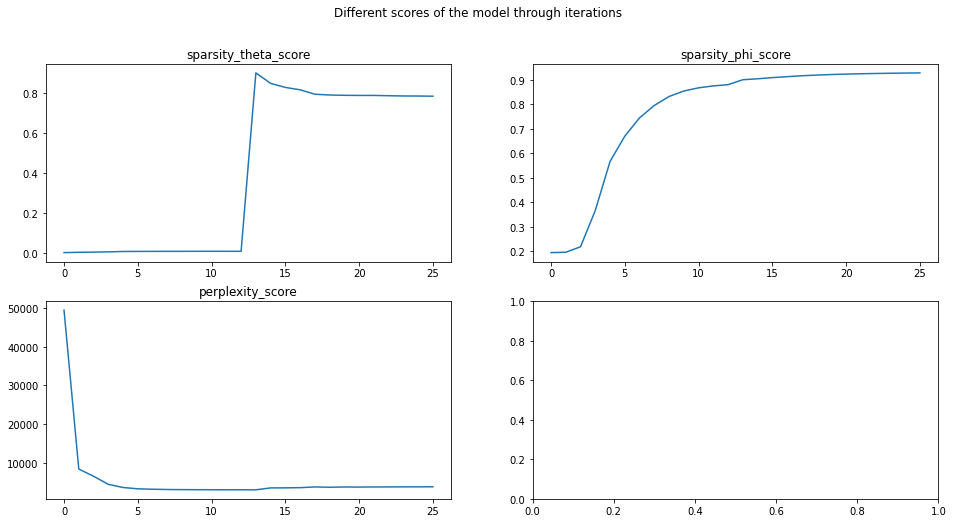

In [100]:
plot_scores(model.score_tracker)

In [101]:
print_topics()

[b'po\xe8tes', b'fran\xe7ais', 'france', 'voltaire', b'fran\xe7aise', b'com\xe9die', 'mois', b'pi\xe8ce', 'industrie', 'mieux']
['busch', b'th\xe9\xe2tre', 'faire', 'liebermann', 'lettre', 'soir', 'petit', 'coup', 'dessin', 'thiers']
['courbet', 'collection', 'manet', 'tableau', 'portrait', 'leibl', b'\x9cuvres', 'paysage', b'th\xe9\xe2tre', 'paris']
[b'mus\xe9e', b'mar\xe9es', 'fut', 'hans', 'arts', b'mus\xe9es', 'guerre', 'erler', 'bulletin', b'd\xe9p\xf4t']
['peinture', 'artistes', 'durer', b'si\xe8cle', 'oeuvre', 'vie', b'ma\xeetre', b'mus\xe9e', 'allemagne', 'saint']
['peinture', 'exposition', 'galerie', 'artistes', 'peintre', 'peintres', b'\x9cuvre', b'\x9cuvres', 'paris', b'\xe9t\xe9']
['paris', 'faire', 'juin', 'monde', b'\x9cuvres', 'aujourd', b'fran\xe7ais', 'ans', 'france', 'exposition']
['holbein', 'dessins', b'mus\xe9e', 'durer', 'portrait', 'portraits', 'dessin', 'oeuvre', b'g\xe9nie', 'vischer']
['maison', 'gropius', 'air', 'architecture', 'salle', b'fa\xe7ade', 'vue', '

In [86]:
save_results()

Now, let's see how the topics are distributed and which documents belong to whcih topic, in order to do quick sanity checks.

In [102]:
p_cd_test = model.transform(batch_vectorizer=batch_vectorizer)

In [103]:
p_cd_test

,14252,14253,14254,14256,14257,14258,14265,14266,14267,14268,...,16383,16384,16385,16402,16429,16431,16432,16434,16435,16436
topic_0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.052742,0.019248,0.000000,0.000000,0.000000,0.000000,0.000000
topic_1,0.0,0.000000,0.645571,0.000000,0.000000,0.000000,0.000000,0.288750,0.0,0.000000,...,0.000000,0.051404,0.000000,0.025716,0.034363,0.000000,0.000000,0.000000,0.000000,0.000000
topic_2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.583223,...,0.000000,0.000000,0.000000,0.000670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.566443,0.451396,0.0,0.018792,...,0.000000,0.000000,0.000000,0.002645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_4,0.0,0.000000,0.000000,0.106057,0.000000,0.000000,0.000000,0.000000,0.0,0.183963,...,0.000000,0.000000,0.000000,0.021191,0.000000,0.000000,0.000000,0.052467,0.000000,0.000000
topic_5,0.0,0.000000,0.000000,0.130646,0.066180,0.167459,0.000000,0.028429,0.0,0.056118,...,0.017248,0.094605,0.680841,0.065694,0.043993,0.234140,0.946622,0.015857,0.000245,0.271429
topic_6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.022247,0.003250,0.047032,0.000000,0.000000,0.925438,0.000000
topic_7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112363,0.0,0.000374,...,0.000000,0.000000,0.000000,0.001296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.248624,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.016404,0.599941,0.000000,0.000000,0.000000,0.000000,0.000000
topic_9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.408036,0.000000,0.000000,0.000000,0.000000


We print the number of document per topics

In [48]:
pd.DataFrame(p_cd_test.idxmax(axis=0)).rename(columns={0: "topic"}).value_counts()

topic   
topic_5     33
topic_12    27
topic_21    27
topic_2     24
topic_13    22
topic_3     19
topic_9     18
topic_6     18
topic_8     17
topic_11    17
topic_7     17
topic_20    17
topic_19    16
topic_17    16
topic_10    16
topic_18    15
topic_14    14
topic_4     13
topic_1     12
topic_16    12
topic_15    12
topic_0     12
dtype: int64

In [104]:
# To decode a word with special caracters like accents
#(b'mar\xe9es').decode("latin-1") 

And we try to come up with names for the topics

In [162]:
topic_names = {
    "topic_0" : "french theater/poetry",
    "topic_1" : "various topics",
    "topic_2" : "XIX french painters",
    "topic_3" : "art guerre/femmes somehow",
    "topic_4" : "impressionisme?",
    "topic_5" : "french exhibitions",
    "topic_6" : "french exhibitions",
    "topic_7" : "german painters/engravers",
    "topic_8" : "building architecture",
    "topic_9" : "russia TODO",
    "topic_10" : "dada",
    "topic_11" : "TODO",
    "topic_12" : "abstract art",
    "topic_13" : "TODO",
    "topic_14" : "religion/cathedrals",
    "topic_15" : "TODO",
    "topic_16" : "handicraft",
    "topic_17" : "TODO",
    "topic_18" : "TODO",
    "topic_19" : "TODO",
    "topic_20" : "XIX german painter ?",
    "topic_21" : "TODO"
}

Let's look at which documents have the 4th topic as prevalent

In [179]:
prohiminent_topics = pd.DataFrame(p_cd_test.idxmax(axis=0)).rename(columns={0: "topic"})
prohiminent_topics[prohiminent_topics["topic"]=="topic_4"]

,topic
14361,topic_4
14975,topic_4
14977,topic_4
15024,topic_4
15343,topic_4
15650,topic_4
15678,topic_4
15687,topic_4
15696,topic_4
15722,topic_4


And we look in more details in the distribution of topic of one specific document.

In [186]:
p_cd_test[16009]

topic_0     0.000000
topic_1     0.111045
topic_2     0.000000
topic_3     0.000000
topic_4     0.888955
topic_5     0.000000
topic_6     0.000000
topic_7     0.000000
topic_8     0.000000
topic_9     0.000000
topic_10    0.000000
topic_11    0.000000
topic_12    0.000000
topic_13    0.000000
topic_14    0.000000
topic_15    0.000000
topic_16    0.000000
topic_17    0.000000
topic_18    0.000000
topic_19    0.000000
topic_20    0.000000
topic_21    0.000000
Name: 16009, dtype: float32